In [205]:
!pip install scikit-learn

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

In [207]:
df = pd.read_csv('GoldUP.csv')


In [208]:
print(df.head())

         Date  Gold_Price  Crude_Oil  Interest_Rate    USD_INR   Sensex  \
0  01-10-2000        4538    1455.51            8.0  46.318297  3711.02   
1  01-11-2000        4483    1512.47            8.0  46.783613  3997.99   
2  01-12-2000        4541    1178.11            8.0  46.745856  3972.12   
3  01-01-2001        4466    1208.18            8.0  46.536033  4326.72   
4  01-02-2001        4370    1267.18            7.5  46.514595  4247.04   

     CPI  USD_Index  
0  37.23     116.65  
1  37.31     115.24  
2  36.98     109.56  
3  36.90     110.52  
4  36.73     112.01  


In [209]:
# Contar valores nulos
print(df.isnull().sum())

Date             0
Gold_Price       0
Crude_Oil        0
Interest_Rate    0
USD_INR          0
Sensex           0
CPI              0
USD_Index        0
dtype: int64


In [210]:
df['Date'] = pd.to_datetime(df['Date']).dropna()

El modelo tiene un comportamiento no estacionario ya que tiene una tendencia creciente a lo largo del tiempo. Para solucionar esto, se puede aplicar una transformación logarítmica a los datos.

(239, 1)

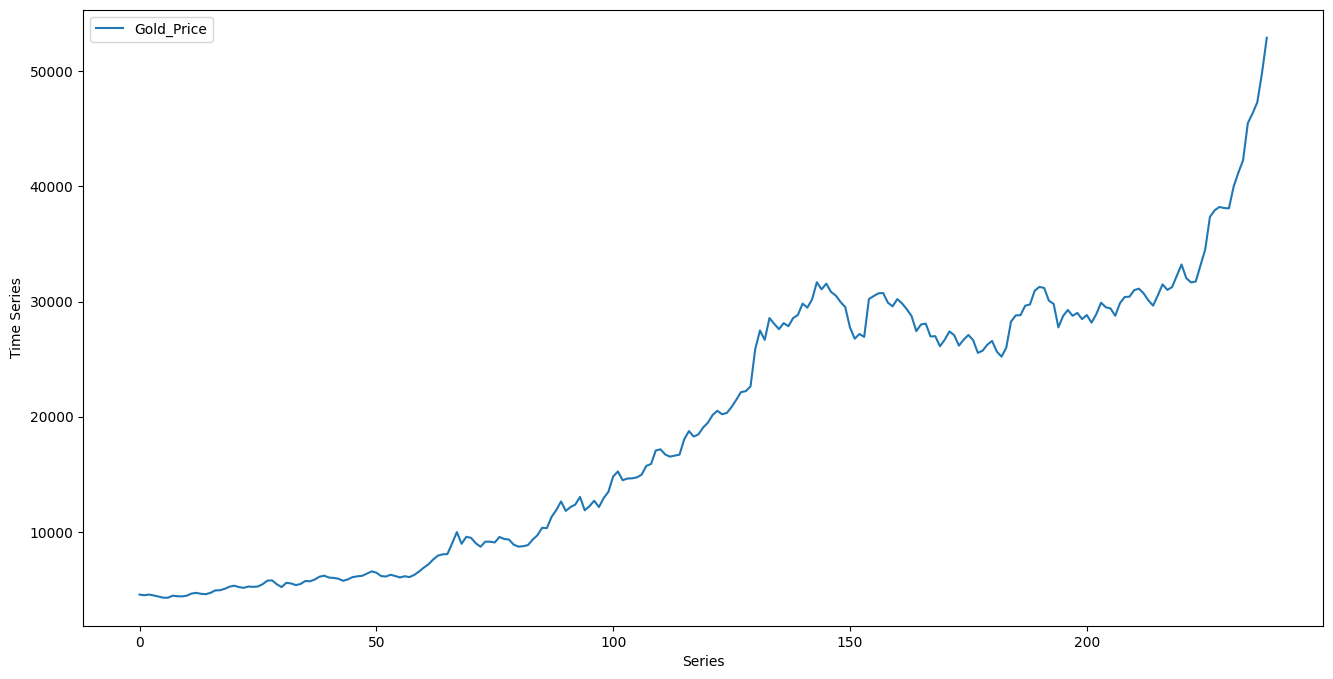

In [211]:
series = pd.DataFrame(data=df['Gold_Price'], columns = ['Gold_Price'] ).dropna()
series.plot(figsize=(16,8))
plt.ylabel('Time Series')
plt.xlabel('Series')
series.shape

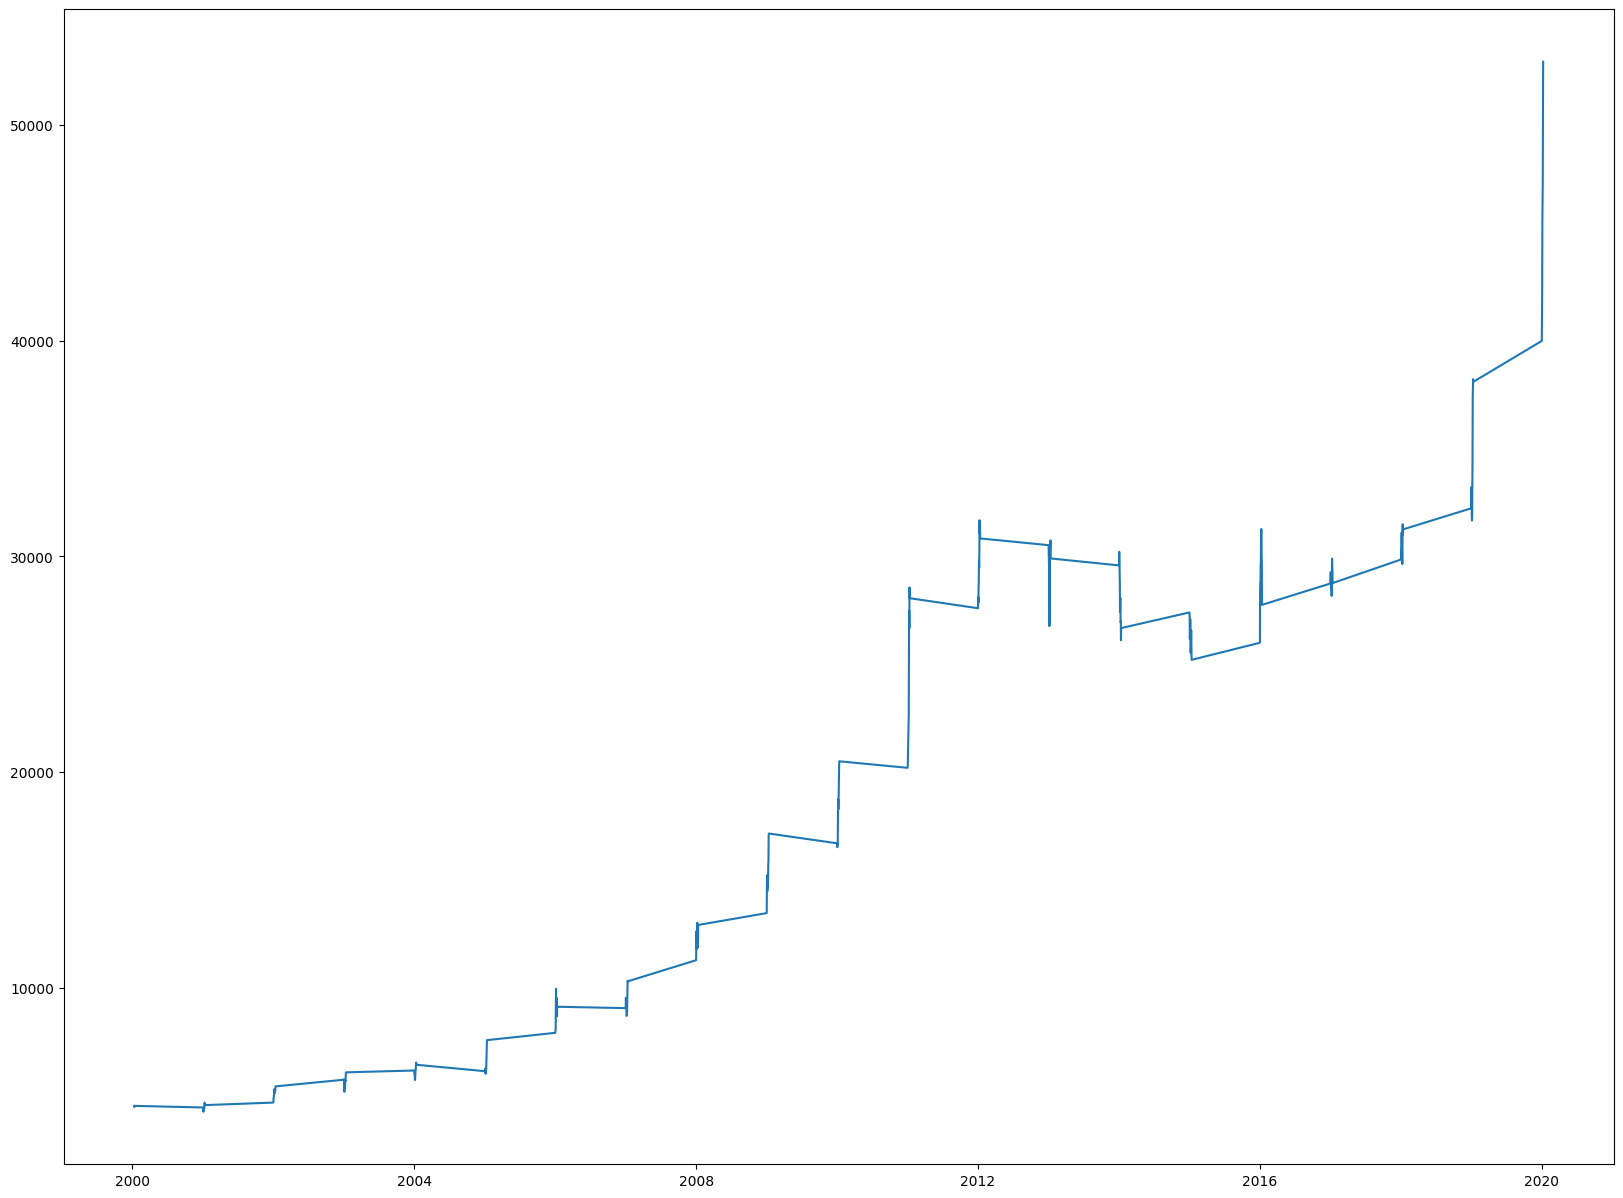

In [212]:
# Se grafica Date vs Gold_Price
# Se ve así por la cercanía de ciertos datos a un mismo período
plt.figure(figsize=(20, 15))
plt.plot(df['Date'], df['Gold_Price'])

Al realizar una prueba formal de estacionariedad (Dickey-Fuller aumentada), se obtiene un p-valor de 0.9989, lo que indica que no se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [213]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Se asegura que la columna Date sea el índice y esté en formato datetime
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Se realiza la prueba ADF sobre la columna Gold_Price
result = adfuller(df['Gold_Price'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: 2.2498926728325603
p-value: 0.9989211091268941
Critical Values 1%: -3.4582467982399105
Critical Values 5%: -2.8738137461081323
Critical Values 10%: -2.5733111490323846


Se pueden observar quiebres estructurales en principalmente tres puntos: 2008, 2012 y 2019.

2008-2012: Se puede observar un aumento sostenido desde el 2008 hasta el 2012 en el precio del oro. Este aumento se puede atribuir a la crisis financiera global que se desató en el 2008. https://www.cmfchile.cl/educa/621/w3-article-27142.html

2012-2019: Se puede observar una estabilización en el precio del oro.

2019-2021: Se puede observar un aumento abrupto en el precio del oro a partir del 2019. Esto puede ser explicado por la crisis financiera y la pandemia de covid en las fechas. https://www.who.int/es/emergencies/diseases/novel-coronavirus-2019

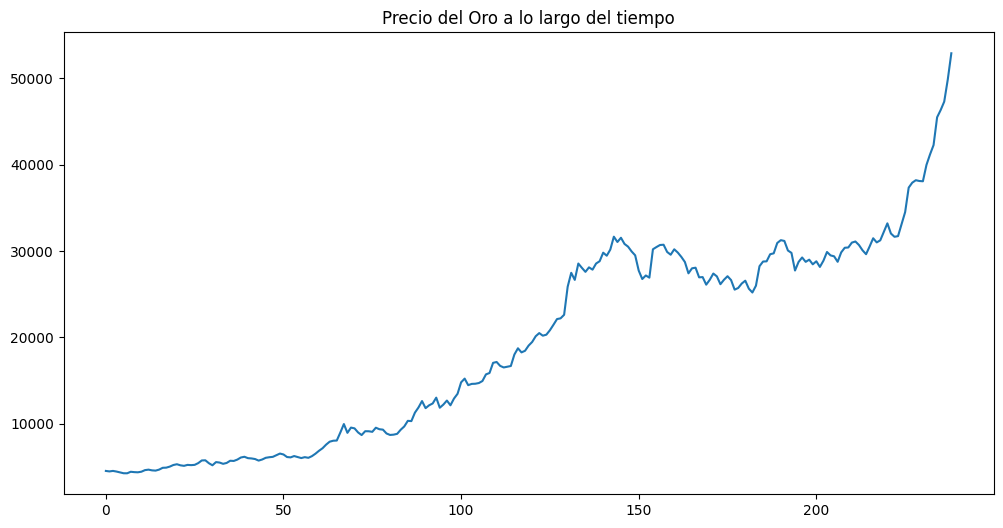

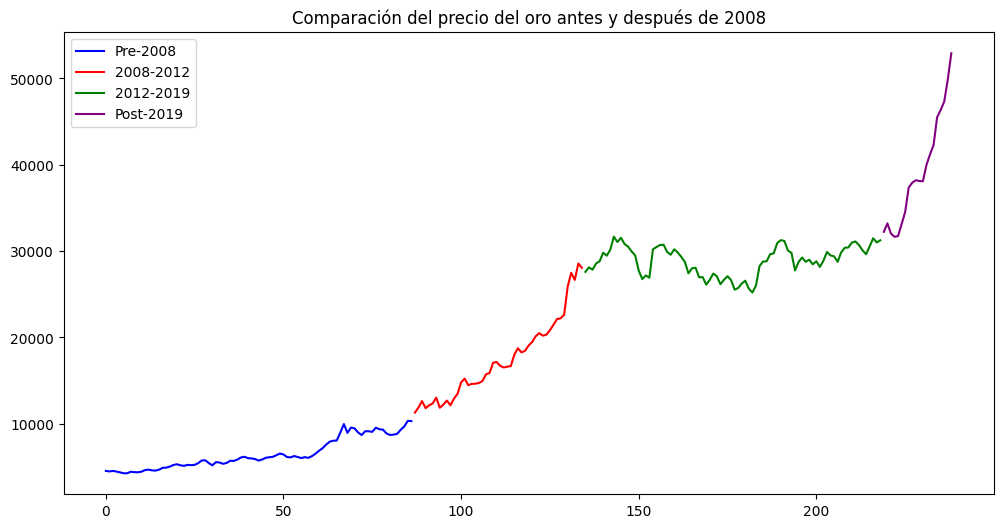

In [214]:
# Se visualizan de nuevo el precio original para detectar quiebres
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Gold_Price'], label='Gold_Price')
plt.title('Precio del Oro a lo largo del tiempo')
plt.show()

# Segmentar por periodos importantes (e.g., antes y después de 2008, 2012, 2019)
df_pre_2008 = df[df['Date'] < '2008-01-01']
df_post_2008 = df[(df['Date'] >= '2008-01-01') & (df['Date'] < '2012-01-01')]
df_post_2012 = df[(df['Date'] >= '2012-01-01') & (df['Date'] < '2019-01-01')]
df_post_2019 = df[df['Date'] >= '2019-01-01']

# Se grafican ambos periodos para ver si hay diferencias visuales
plt.figure(figsize=(12,6))
plt.plot(df_pre_2008.index, df_pre_2008['Gold_Price'], label='Pre-2008', color='blue')
plt.plot(df_post_2008.index, df_post_2008['Gold_Price'], label='2008-2012', color='red')
plt.plot(df_post_2012.index, df_post_2012['Gold_Price'], label='2012-2019', color='green')
plt.plot(df_post_2019.index, df_post_2019['Gold_Price'], label='Post-2019', color='purple')
plt.title('Comparación del precio del oro antes y después de 2008')
plt.legend()
plt.show()

Se aplica una diferenciación en los datos para eliminar la tendencia

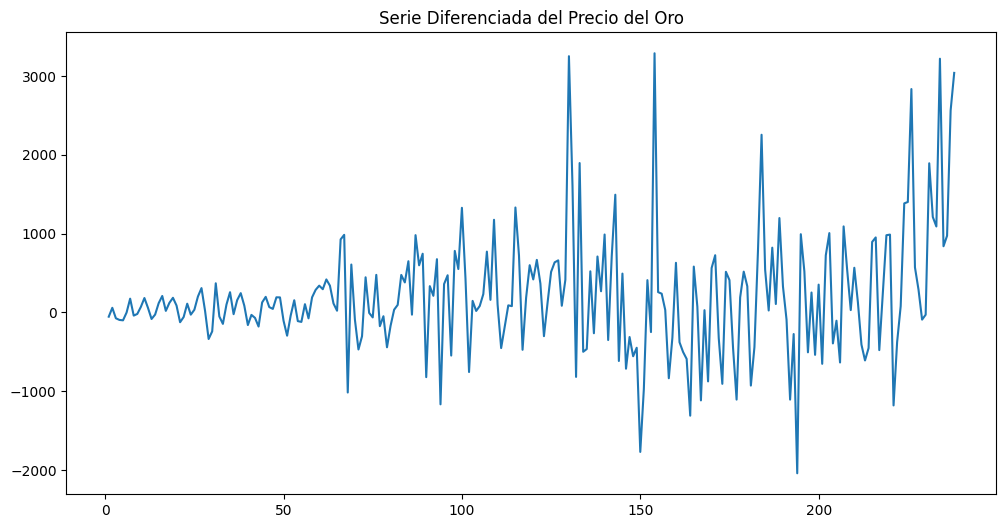

In [215]:
# Se aplica una diferenciación para eliminar la tendencia
df['Gold_Price_diff'] = df['Gold_Price'].diff().dropna()
# Se grafica la serie diferenciada
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Gold_Price_diff'], label='Gold_Price_diff')
plt.title('Serie Diferenciada del Precio del Oro')
plt.show()

Al probar la estacionariedad de los datos diferenciados, se obtiene un p-valor de 1.72e-21, lo que indica que se puede rechazar la hipótesis nula de que los datos no son estacionarios.

In [216]:
# Prueba ADF en la serie diferenciada
result_diff = adfuller(df['Gold_Price_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -11.683289917156333
p-value: 1.720786939407828e-21
Critical Values 1%: -3.4582467982399105
Critical Values 5%: -2.8738137461081323
Critical Values 10%: -2.5733111490323846


In [230]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['Gold_Price_diff'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['Gold_Price_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    print(f'AR({lag}): R² ajustado = {r2_adj}, Error Promedio (MSE) = {mse}')

AR(1): R² ajustado = -0.13654684030538955, Error Promedio (MSE) = 1113.19938595275
AR(2): R² ajustado = -0.14096300684205443, Error Promedio (MSE) = 1112.3250141287708
AR(3): R² ajustado = -0.12041782030207204, Error Promedio (MSE) = 1099.2489892592246
AR(4): R² ajustado = -0.16551105381167175, Error Promedio (MSE) = 1118.0670864642132


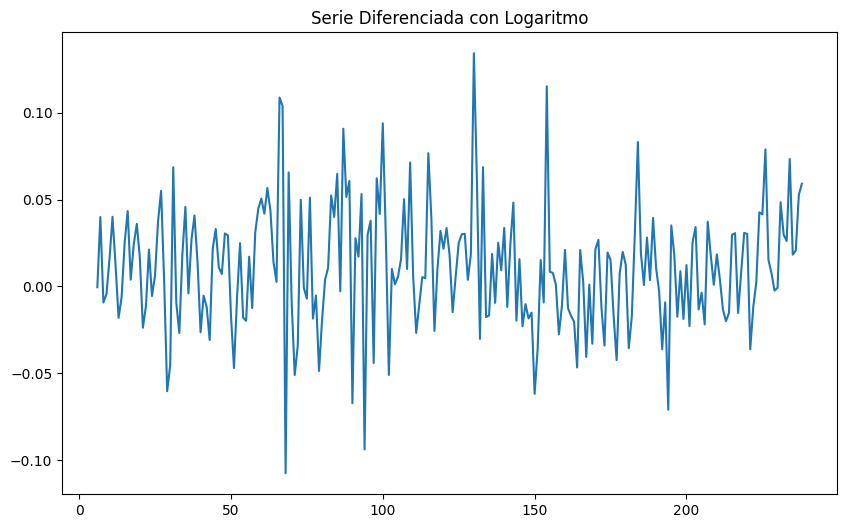

AR(1): R2 ajustado = 0.9975202210324758, Error Promedio (MSE) = 0.035288114605404534
AR(2): R2 ajustado = 0.9975307466712033, Error Promedio (MSE) = 0.03513583655611527
AR(3): R2 ajustado = 0.9975288687553743, Error Promedio (MSE) = 0.035071688177204685
AR(4): R2 ajustado = 0.9975339915858037, Error Promedio (MSE) = 0.034957718572865226


In [218]:
# Se aplica el logaritmo para estabilizar la varianza antes de diferenciar
import numpy as np
df['Log_Gold_Price'] = np.log(df['Gold_Price'])
df['Log_Gold_Price_diff'] = df['Log_Gold_Price'].diff()
# Se grafica la serie log-diferenciada
plt.figure(figsize=(10,6))
plt.plot(df['Log_Gold_Price_diff'], label='Log_Differenced_Gold_Price')
plt.title('Serie Diferenciada con Logaritmo')
plt.show()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['Log_Gold_Price'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['Log_Gold_Price']
models = {}
for ar in range(1, 5):
    X_ar = X.iloc[:, :ar]
    model = LinearRegression()
    model.fit(X_ar, y)
    models[f'AR({ar})'] = model
    predictions = model.predict(X_ar)
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y, predictions)) * (len(y) - 1) / (len(y) - X_ar.shape[1] - 1)
    mse = root_mean_squared_error(y, predictions)
    print(f'AR({ar}): R2 ajustado = {r2_adj}, Error Promedio (MSE) = {mse}')

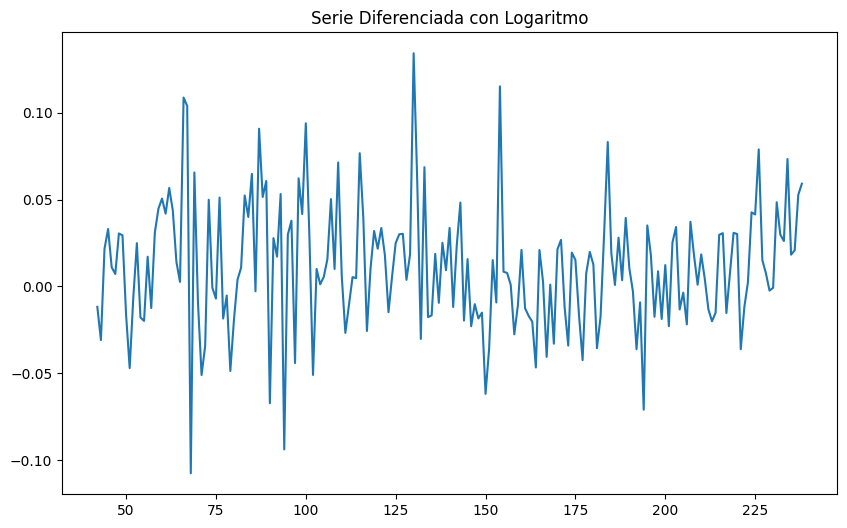

AR(1): R2 ajustado = 0.9673065155025822, Error Promedio (MSE) = 0.030702634730874267
AR(2): R2 ajustado = 0.9681642791530294, Error Promedio (MSE) = 0.030218190436521044
AR(3): R2 ajustado = 0.9678307750526992, Error Promedio (MSE) = 0.030296434838705456
AR(4): R2 ajustado = 0.967987351208553, Error Promedio (MSE) = 0.030142976387364604


In [228]:
# Se aplica el logaritmo para estabilizar la varianza antes de diferenciar
import numpy as np
df['Log_Gold_Price'] = np.log(df['Gold_Price'])
df['Log_Gold_Price_diff'] = df['Log_Gold_Price'].diff()
# Se grafica la serie log-diferenciada
plt.figure(figsize=(10,6))
plt.plot(df['Log_Gold_Price_diff'], label='Log_Differenced_Gold_Price')
plt.title('Serie Diferenciada con Logaritmo')
plt.show()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Se crean las variables lag (rezagadas) para AR(1) a AR(4)
for lag in range(1, 5):
    df[f'lag_{lag}'] = df['Log_Gold_Price'].shift(lag)
# Se eliminan los valores NaN generados por las lags
df.dropna(inplace=True)
# Se configura el modelo de regresión para cada AR(p)
X = df[[f'lag_{i}' for i in range(1, 5)]]
y = df['Log_Gold_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
models = {}
for lag in range(1, 5):
    X_lag = X.iloc[:, :lag]
    X_lag_train = X_train.iloc[:, :lag]
    X_lag_test = X_test.iloc[:, :lag]
    model = LinearRegression()
    model.fit(X_lag_train, y_train)
    models[f'AR({lag})'] = model
    predictions = model.predict(X_lag_test)
    # Se evalúa el modelo
    r2_adj = 1 - (1 - r2_score(y_test, predictions)) * (len(y) - 1) / (len(y) - X_lag.shape[1] - 1)
    mse = root_mean_squared_error(y_test, predictions)
    print(f'AR({lag}): R2 ajustado = {r2_adj}, Error Promedio (MSE) = {mse}')